<a href="https://colab.research.google.com/github/Douglas03112/Google_ML_predict_house_value/blob/main/google_ML_house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import relevant modules
import pandas as pd
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import numpy as np

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [ ]:
# Import the dataset.
training_df = pd.read_csv(filepath_or_buffer="https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")

# Scale the label.
training_df["median_house_value"] /= 1000.0

# Print the first rows of the pandas DataFrame.
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5


In [ ]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [ ]:
# Get statistics on the dataset.
training_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [ ]:
#@title Double-click to view a possible answer.

# The maximum value (max) of several columns seems very
# high compared to the other quantiles. For example,
# example the total_rooms column. Given the quantile
# values (25%, 50%, and 75%), you might expect the
# max value of total_rooms to be approximately
# 5,000 or possibly 10,000. However, the max value
# is actually 37,937.

# When you see anomalies in a column, become more careful
# about using that column as a feature. That said,
# anomalies in potential features sometimes mirror
# anomalies in the label, which could make the column
# be (or seem to be) a powerful feature.
# Also, as you will see later in the course, you
# might be able to represent (pre-process) raw data
# in order to make columns into useful features.

In [ ]:
#@title Define the functions that build and train a model
import sklearn
from sklearn.model_selection import train_test_split  # Add this import statement

def build_model(my_learning_rate, input, depth=1):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()
  model.add(tf.keras.Input(shape=(input,)))
  for _ in range(0,depth) :
    model.add(keras.layers.Dense(10, activation=('relu'))) #set the width of the model = 10
  model.add(keras.layers.Dense(1))
  model.summary()

  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  #model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Compile the model topography into code that TensorFlow can efficiently
  # execute. Configure training to minimize the model's mean squared error.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

def train_model(model, df, feature, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Split the data into features and labels
  features = (df[feature] - np.mean(df[feature])) / np.std(df[feature])
  labels = df[label]

  # Use train_test_split to get training and testing sets
  train_features, test_features, train_labels, test_labels = train_test_split(
      features, labels, test_size=0.3, random_state=0)

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs.
  history = model.fit(x=train_features,
                      y=train_labels,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(test_features, test_labels))  # Add validation_data

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the error for each epoch.
  hist = pd.DataFrame(history.history)

  # To track the progression of training, we're going to take a snapshot
  # of the model's root mean squared error at each epoch.
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse, test_features, test_labels

print("Defined the build_model and train_model functions.")


Defined the build_model and train_model functions.


In [ ]:
#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against 200 random training examples."""

  # Label the axes.
  plt.xlabel(feature)
  plt.ylabel(label)

  # Create a scatter plot from 200 random points of the dataset.
  random_examples = training_df.sample(n=200)
  plt.scatter(random_examples[feature], random_examples[label])

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = random_examples[feature].max()
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  # Set the lower limit of Y-axis slightly below the minimum RMSE (97%)
  # to give visual padding at the bottom of the chart.
  plt.show()

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                20        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 471 (1.84 KB)
Trainable params: 471 (1.84 

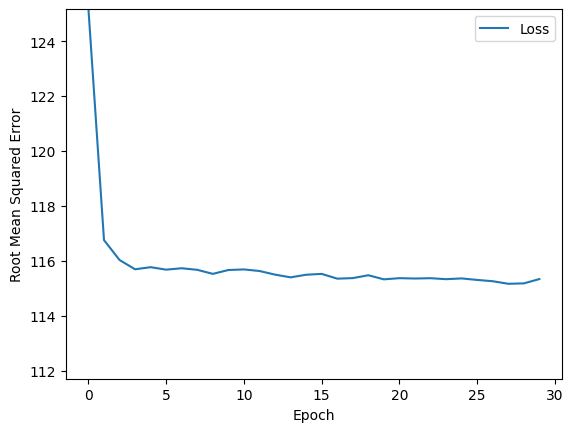

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 30
batch_size = 30

# Specify the feature and the label.
my_feature = "total_rooms"  # the total number of rooms on a specific city block.
my_label="median_house_value" # the median value of a house on a specific city block.
# That is, you're going to create a model that predicts house value based
# solely on total_rooms.

# Don't change anything below this line.
my_model = build_model(learning_rate, input=1, depth=5)
weight, bias, epochs, mae, test_features, test_labels = train_model(my_model, training_df,
                                        my_feature, my_label,
                                        epochs, batch_size)

print("\nThe learned weight for your model is ", weight)
print("The learned bias for your model is ", bias )

plot_the_loss_curve(epochs, mae)

In [ ]:
def predict_house_values(n, test_features, test_labels):
  """Predict house values based on a feature."""

  predicted_values = my_model.predict_on_batch(x=test_features)
  loss, rmse = my_model.evaluate(x=test_features, y=test_labels)
  test_features = test_features.reset_index(drop=True)
  test_labels = test_labels.reset_index(drop=True)

  print("Loss: ", loss)
  print("RMSE: ", rmse)

  print("label          predicted")
  print("value          value")
  print("in thousand$   in thousand$")
  print("--------------------------------------")
  for i in range(n):
    print ("%6.0f %15.0f" % (test_labels[i],
                                   predicted_values[i][0] ))

In [ ]:
#@title Double-click to view the answer.

# Most of the predicted values differ significantly
# from the label value, so the trained model probably
# doesn't have much predictive power. However, the
# first 10 examples might not be representative of
# the rest of the examples.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                20        
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 10)                110       
                                                                 
 dense_9 (Dense)             (None, 10)                110       
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 471 (1.84 KB)
Trainable params: 471 (1.8

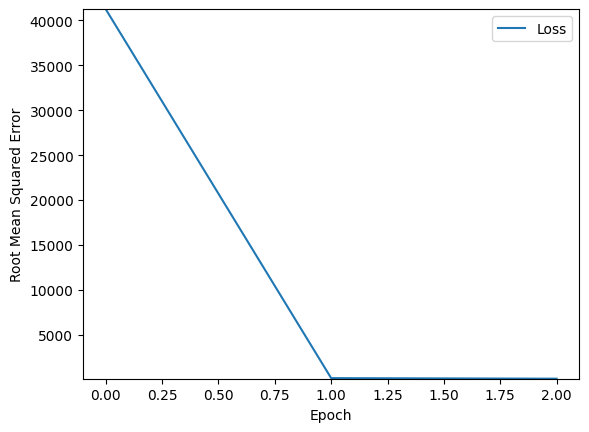

160/160 [==============================] - 0s 2ms/step - loss: 13239.1572 - root_mean_squared_error: 115.0615
Loss:  13239.1572265625
RMSE:  115.06153869628906
label          predicted
value          value
in thousand$   in thousand$
--------------------------------------
   171             206
   190             206
   500             206
   229             206
   163             206
   263             206
   364             206
   247             206
   208             206
   108             206
   230             206
   311             206
   140             206
   122             206
   258             206


In [ ]:
my_feature = "population"   # Replace the ? with population or possibly
                            # a different column name.
my_label="median_house_value"

# Experiment with the hyperparameters.
learning_rate = 2
epochs = 3
batch_size = 120

# Don't change anything below this line.
my_model = build_model(learning_rate, input=1, depth=5)
weight, bias, epochs, mae, test_features, test_labels = train_model(my_model, training_df,
                                        my_feature, my_label,
                                        epochs, batch_size)

print("\nThe learned weight for your model is ", weight)
print("The learned bias for your model is ", bias )

plot_the_loss_curve(epochs, mae)
predict_house_values(15, test_features, test_labels)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                20        
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dense_14 (Dense)            (None, 10)                110       
                                                                 
 dense_15 (Dense)            (None, 10)                110       
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 471 (1.84 KB)
Trainable params: 471 (1.8

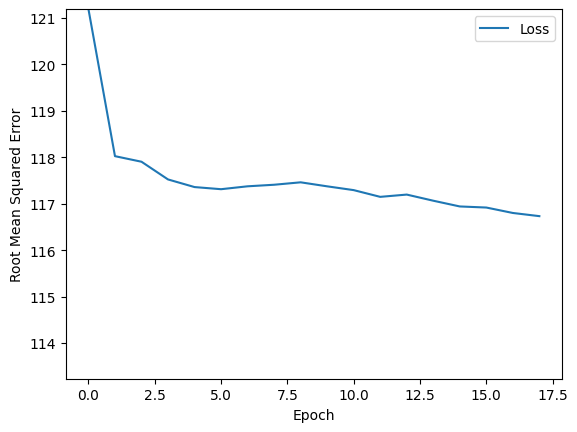

160/160 [==============================] - 0s 2ms/step - loss: 13298.7588 - root_mean_squared_error: 115.3202
Loss:  13298.7587890625
RMSE:  115.32024383544922
label          predicted
value          value
in thousand$   in thousand$
--------------------------------------
   171             214
   190             214
   500             214
   229             214
   163             214
   263             214
   364             214
   247             214
   208             214
   108             214
   230             214
   311             214
   140             214
   122             214
   258             214


In [ ]:
#@title Double-click to view a possible solution.

my_feature = "population" # Pick a feature other than "total_rooms"
my_label="median_house_value"

# Possibly, experiment with the hyperparameters.
learning_rate = 0.05
epochs = 18
batch_size = 3

# Don't change anything below this line.
my_model = build_model(learning_rate, input=1, depth=5)
weight, bias, epochs, mae, test_features, test_labels = train_model(my_model, training_df,
                                        my_feature, my_label,
                                        epochs, batch_size)

print("\nThe learned weight for your model is ", weight)
print("The learned bias for your model is ", bias )

plot_the_loss_curve(epochs, mae)
predict_house_values(15, test_features, test_labels)

In [ ]:
#@title Double-click to view the answer.

# Training is not entirely deterministic, but population
# typically converges at a slightly higher RMSE than
# total_rooms.  So, population appears to be about
# the same or slightly worse at making predictions
# than total_rooms.

In [ ]:
# Generate a correlation matrix.
training_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0


<Axes: >

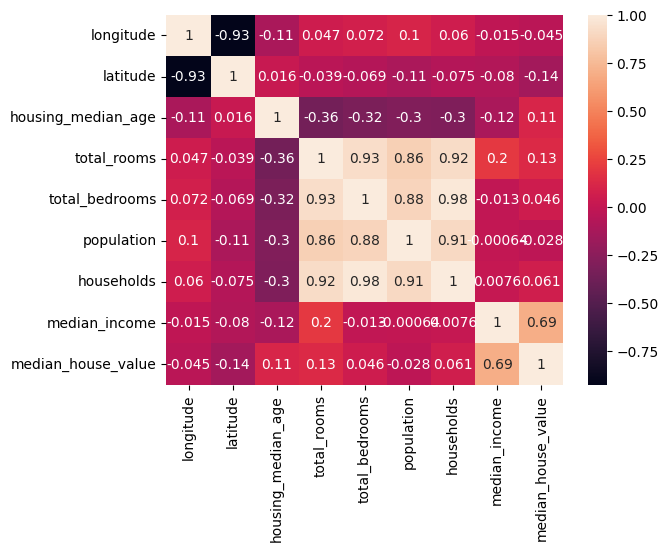

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate Pearson correlation matrix between all numeric columns
cor = training_df.corr(method='pearson')

# Plot heatmap of the correlation matrix with value annotations in each cell
sns.heatmap(cor, annot = True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                90        
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dense_14 (Dense)            (None, 10)                110       
                                                                 
 dense_15 (Dense)            (None, 10)                110       
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 541 (2.11 KB)
Trainable params: 541 (2.1

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


397/397 [==============================] - 3s 5ms/step - loss: 7184.2144 - root_mean_squared_error: 84.7597 - val_loss: 4372.9712 - val_root_mean_squared_error: 66.1284
Epoch 2/30
397/397 [==============================] - 2s 4ms/step - loss: 4629.9141 - root_mean_squared_error: 68.0435 - val_loss: 4922.0669 - val_root_mean_squared_error: 70.1574
Epoch 3/30
397/397 [==============================] - 2s 6ms/step - loss: 4500.5835 - root_mean_squared_error: 67.0864 - val_loss: 4228.2886 - val_root_mean_squared_error: 65.0253
Epoch 4/30
397/397 [==============================] - 2s 5ms/step - loss: 4332.1997 - root_mean_squared_error: 65.8195 - val_loss: 5672.4009 - val_root_mean_squared_error: 75.3153
Epoch 5/30
397/397 [==============================] - 2s 4ms/step - loss: 4358.8779 - root_mean_squared_error: 66.0218 - val_loss: 4358.1641 - val_root_mean_squared_error: 66.0164
Epoch 6/30
397/397 [==============================] - 2s 4ms/step - loss: 4326.7842 - root_mean_squared_error: 

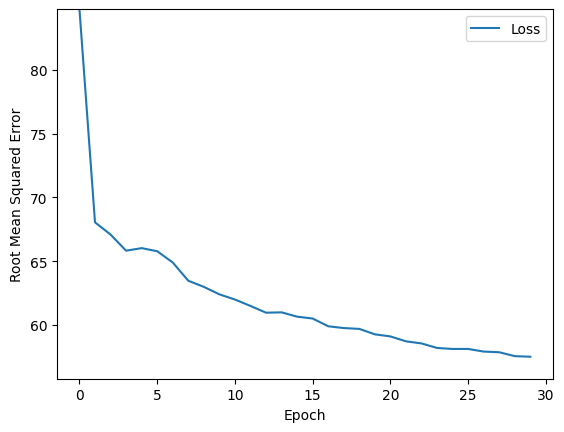

160/160 [==============================] - 0s 2ms/step - loss: 3775.6509 - root_mean_squared_error: 61.4463
Loss:  3775.65087890625
RMSE:  61.44632339477539
label          predicted
value          value
in thousand$   in thousand$
--------------------------------------
   171             182
   190             158
   500             436
   229             247
   163             212
   263             270
   364             241
   247             252
   208             249
   108             100
   230             183
   311             252
   140             153
   122             127
   258             221
1/1 [==============================] - 0s 63ms/step


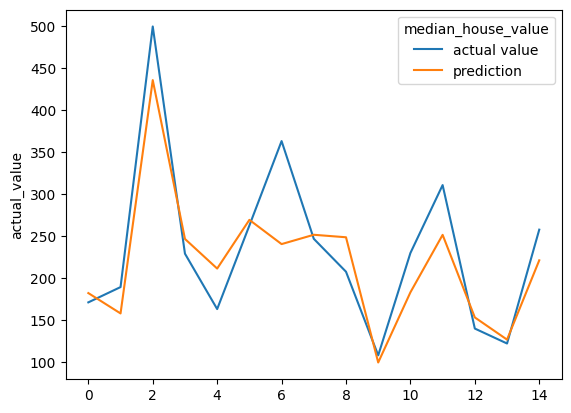

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 30
batch_size = 30

# Specify the feature and the label.
#my_feature = ["median_income"]  # the total number of rooms on a specific city block.
my_feature = ['longitude', 'latitude', 'median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'households', 'population']
my_label="median_house_value" # the median value of a house on a specific city block.
# That is, you're going to create a model that predicts house value based
# solely on total_rooms.

# Don't change anything below this line.
my_model = build_model(learning_rate, input=8, depth=5) #set the depth of the model = 5
weight, bias, epochs, mae, test_features, test_labels = train_model(my_model, training_df,
                                        my_feature, my_label,
                                        epochs, batch_size)

print("\nThe learned weight for your model is ", weight)
print("The learned bias for your model is ", bias )

plot_the_loss_curve(epochs, mae)
predict_house_values(15, test_features, test_labels)

#df = pd.DataFrame({'actual_value': test_labels[5000:10020], 'prediction': my_model.predict(test_features[5000:10020]).flatten()})
df = pd.DataFrame({'actual_value': test_labels.iloc[:15], 'prediction': my_model.predict(test_features[:15]).flatten()})
df = df.reset_index(drop=True)

sns.lineplot(data=df, x=df.index, y='actual_value', label='actual value')
sns.lineplot(data=df, x=df.index, y='prediction', label='prediction')
plt.legend(title='median_house_value')
plt.show()